# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#adding other required libraries
import math
import os

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


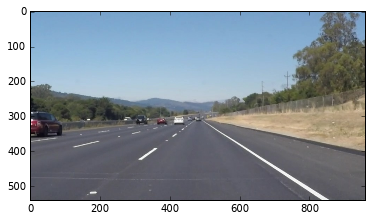

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def filter_lines(lines, position):
    X = []
    Y = []
    
    # coordinates for fitting final line
    points = []

    if position=='left':
        max_slope = -0.4
        min_slope = -0.8
        
    elif position=='right':
        max_slope = 0.8
        min_slope = 0.4
        
    # generate points for final line
    for line in lines:
        for x1, y1, x2, y2 in line:
    
            # should be good slope first
            slope = (y2 - y1) / (x2 - x1)
            if (slope > min_slope) & (slope < max_slope):

                # longer lines gave more votes
                length = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
                if length > 15:
                    for x in range(int(length)):
                        X.extend((x1, x2))
                        Y.extend((y1, y2))
        
    # remove outliers (soft version)
    X = np.array(X)
    Y = np.array(Y)
    
    mu_x = X.mean()
    sigma_x = X.std()
    
    mu_y = Y.mean()
    sigma_y = Y.std()
    
    good_x_bool =  (X > (mu_x - 2 * sigma_x)) & (X < (mu_x + 2 * sigma_x))
    
    good_y_bool =  (Y > (mu_y - 2 * sigma_y)) & (Y < (mu_y + 2 * sigma_y))
    
    good = good_x_bool & good_y_bool
    
    X_final, Y_final = X[good], Y[good]
    
    # fit line
    
    line = np.polyfit(X_final, Y_final, 1)
    
    top_y = min(Y_final)
    
    return (line, top_y)

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def initialize_smooth(smooth_depth):
    coordinates = [(0,0,0,0,0,0,0,0),] * (smooth_depth)
    return coordinates

def remove_asphalt(image):
    low_threshold = np.array([0, 0, 0])
    high_threshold = np.array([255, 100, 220])

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(image_hsv, low_threshold, high_threshold)

    image[mask>0] = [0,0,0]
    
    return image

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
# choose depth of smoothing

smooth_depth = 5

# initialize coordinates for smoothing

smooth_coords = initialize_smooth(smooth_depth)

# process image function
def process_image(img):
    
    height, width = img.shape[0], img.shape[1]
    
    global smooth_lines
    global smooth_depth
    
    # define parameters
    
    kernel_size = 5

    low_threshold = 75
    high_threshold = 200

    rho = 2
    theta = 2 * np.pi / 180
    threshold = 5
    min_line_len = 20
    max_line_gap = 100
    
    vertices_left_line = np.array([[(0.05*width, 1.00*height),
                                    (0.47*width, 0.58*height),
                                    (0.53*width, 0.58*height),
                                    (0.30*width, 1.00*height)]], dtype=np.int32)

    vertices_right_line = np.array([[(0.95*width, 1.00*height),
                                     (0.53*width, 0.58*height),
                                     (0.47*width, 0.58*height),
                                     (0.70*width, 1.00*height)]], dtype=np.int32)
      
    # remove asphalt
    black_asphalt = remove_asphalt(np.copy(img))
    
    
    # grayscale and blur
    gray = grayscale(black_asphalt)
    blurred_gray = gaussian_blur(gray, kernel_size)
    
    # canny edge detection    
    edges = canny(blurred_gray, low_threshold, high_threshold)
    
    # a lot of hough lines
    cropped_left = region_of_interest(edges, vertices_left_line)
    cropped_right = region_of_interest(edges, vertices_right_line)
        
    left_lines = hough_lines(cropped_left, rho, theta, threshold, min_line_len, max_line_gap)
    right_lines = hough_lines(cropped_right, rho, theta, threshold, min_line_len, max_line_gap)
    
    # filter lines and define min y for both sides
    left_line, left_top_y = filter_lines(left_lines, position='left')
    right_line, right_top_y = filter_lines(right_lines, position='right')
    
    top_y = max(left_top_y, right_top_y, height * 0.6)
    
    # calculate coordinates of triangle upper vertice
    
    left_X1 = [lines[0] for lines in smooth_coords]
    left_Y1 = [lines[1] for lines in smooth_coords]
    left_X2 = [lines[2] for lines in smooth_coords]
    left_Y2 = [lines[3] for lines in smooth_coords]
    
    right_X1 = [lines[4] for lines in smooth_coords]
    right_Y1 = [lines[5] for lines in smooth_coords]
    right_X2 = [lines[6] for lines in smooth_coords]
    right_Y2 = [lines[7] for lines in smooth_coords]

    left_slope = left_line[0]
    left_intercept = left_line[1]
    
    right_slope = right_line[0]
    right_intercept = right_line[1]
    
    # predicting values
    left_y1 = height
    left_x1 = (height - left_intercept)/left_slope
 
    left_y2 = top_y
    left_x2 = (left_y2 - left_intercept)/left_slope
    
    right_y1 = top_y
    right_x1 = (right_y1 - right_intercept)/right_slope

    right_y2 = height
    right_x2 = (height - right_intercept)/right_slope 
    
    # updating smoothing array
    new_coords = (left_x1, left_y1, left_x2, left_y2,
                  right_x1, right_y1, right_x2, right_y2)
    
    del smooth_coords[0]
    smooth_coords.append(new_coords)
    
    # calculating current coordinates from smoothing array
    smooth_left_x1 = sum(left_X1) / smooth_depth
    smooth_left_y1 = sum(left_Y1) / smooth_depth
    smooth_left_x2 = sum(left_X2) / smooth_depth
    smooth_left_y2 = sum(left_Y2) / smooth_depth
    
    smooth_right_x1 = sum(right_X1) / smooth_depth
    smooth_right_y1 = sum(right_Y1) / smooth_depth
    smooth_right_x2 = sum(right_X2) / smooth_depth
    smooth_right_y2 = sum(right_Y2) / smooth_depth
    
    # draw good lines on black
        
    goodlines = np.array([[[smooth_left_x1, smooth_left_y1,
                            smooth_left_x2, smooth_left_y2]],
                          [[smooth_right_x1, smooth_right_y1,
                            smooth_right_x2, smooth_right_y2]]],dtype=np.int32)
    


    # merge with original image
    
    
    black_img = np.zeros_like(img)
    draw_lines(black_img, goodlines, thickness=10)
    
    result = weighted_img(black_img, img)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 49.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.42 s, sys: 248 ms, total: 4.67 s
Wall time: 4.85 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:13<00:00, 50.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 13 s, sys: 928 ms, total: 13.9 s
Wall time: 13.8 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


What an interesting project!

I found lane lines for first two projects fairly easily. But I didn't want to stop and continued better solution.

I was inspired by fellow classmates and finally finished solution.

My current algorithm will fail if he can't find lines of good slope (between +-0.4 and 0.8) on each side or if the road is too dirty.

I have non ideal start because I've spent sooo much time on this project that I decided to initialize coordinates for smoothing as 0. That's why first frames have inaccurate lanes and my function works bad for standalone images. I can improve by making smoothing coordinates initialization rely on first frame of the video.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 29%|██▊       | 72/251 [00:02<00:05, 30.73it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))